In [193]:
# %load_ext autoreload
# %autoreload 2


In [61]:
import warnings
warnings.filterwarnings("ignore")

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from logger import logger
# from utils import evaluate_binary, log_mlflow

In [63]:
from typing import Dict, Any, Tuple
from typing import Optional
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from joblib import dump
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import yaml
from logger import logger
import mlflow.sklearn
from mlflow.tracking import MlflowClient

def plot_roc(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plot the area under curve for the ROC curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:
        Output path of plot
    """
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.grid()
    plt.plot(fpr, tpr, color='b')
    plt.title('ROC curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}\\plots\\roc_curve_{}.png'.format(plot_dir, model_name)
        plt.savefig(output_path)
        logger.info('ROC curve saved to: {}'.format(output_path))
        return output_path


def plot_precision_recall(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plots the precision-recall curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:Ø
        Output path of plot
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.plot(thresholds, precision[1:], color='r', label='Precision')
    plt.plot(thresholds, recall[1:], color='b', label='Recall')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.title('Precision-recall curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}/plots/precision_recall_{}.png'.format(plot_dir, model_name)
        
        plt.savefig(output_path)
        logger.info('Precision-recall curve saved to: {}'.format(output_path))
        return output_path


def save_model(model: Any, model_name: str, model_dir: str) -> str:
    """
    Saves model in pickle format

    Args:
        model: Model binary
        model_name: Name of model
        model_dir: Directory to save model in

    Returns:
        Output path of model
    """
    Path(f"{model_dir}/models").mkdir(parents=True, exist_ok=True)
    output_path = '{}/models/{}.pickle'.format(model_dir, model_name)
    logger.info('Model saved to: {}'.format(output_path))
    dump(model, output_path)

    return output_path


def evaluate_binary(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5) -> \
        Tuple[float, float, float, float]:
    """
    Returns binary evaluation metrics

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        threshold: Threshold to convert probabilies to binary values (default=0.5)

    Returns:
        Metrics for AUC, recall, precision, and F1
    """
    y_pred_thresholded = np.where(y_pred > threshold, 1, 0)

    auc = roc_auc_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred_thresholded)
    precision = precision_score(y_true, y_pred_thresholded)
    f1 = f1_score(y_true, y_pred_thresholded)

    logger.info('AUC: {:.3f} | Recall: {:.3f} | Precision: {:.3f} | F1: {:.3f}'.format(auc, recall, precision, f1))
    return auc, recall, precision, f1


def save_metrics(auc,recall, precision,f1, metrics_dir: str, metrics_name:str)-> None:
    # Calculate metrics
    metrics = {}

    metrics["auc"] = float(auc)
    metrics["precision"] = float(precision)
    metrics["recall"] = float(recall)
    metrics["f1"] = float(f1)
    Path(f"{metrics_dir}/metrics").mkdir(parents=True, exist_ok=True)
    output_path = f"{metrics_dir}\\metrics\\{metrics_name}_mertics.yaml"
    logger.info('Model metrics to: {}'.format(output_path))
    with open(output_path, 'w+') as file:
        yaml.dump(metrics, file, default_flow_style=False)
        
def log_mlflow(experiment_id,run_params: Dict, model: Any, model_name: str, y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Logs result of model training and validation to mlflow

    Args:
        run_params: Dictionary containing parameters of run.
                    Expects keys for 'experiment', 'artifact_dir', 'iteration', and 'index.
        model: Model binary
        model_name: Name of model
        y_true: Array of true y values
        y_pred: Array of predicted y values

    Returns:
        None
    """
    
#     mlflow.set_tracking_uri("http://127.0.0.1:5000")
#     mlflow.set_experiment()
# 
    auc, recall, precision, f1 = evaluate_binary(y_true, y_pred)
    
    save_metrics(auc,recall ,precision,f1, metrics_dir= run_params['artifact_dir'],metrics_name =model_name+ "_" +run_params["country"])

    roc_path = plot_roc(y_true, y_pred, '{} (auc = {:.2f})'.format(model_name, auc), run_params['artifact_dir'])
    pr_path = plot_precision_recall(y_true, y_pred,
                                    '{} prec= {:.2f} recall= {:.2f}'.format(model_name, precision, recall),
                                    run_params['artifact_dir'])
    model_path = save_model(model, model_name, run_params['artifact_dir'])
    print(model_path)
    
    with mlflow.start_run(experiment_id=experiment_id,run_name=run_params['iteration']):
#         mlflow.sklearn.autolog() 
        mlflow.log_param('country', run_params['country'])
        mlflow.log_param('model', model_name)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('f1', f1)
        mlflow.log_artifact(model_path)
        mlflow.log_artifact(roc_path)
        mlflow.log_artifact(pr_path)
        mlflow.sklearn.log_model(model, model_name,
                                registered_model_name=f"{COUNTRY}_{model_name}")
        
        # Instantiate the Path class
#         obj = Path(model_path)
#         obj.unlink(missing_ok=True)
#         mlflow.sklearn.save_model(model, model_path,
#                           serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
        
        # Logging model to MLFlow
#         mlflow.sklearn.log_model(sk_model = model,
#                              artifact_path = model_path,
#                              registered_model_name = 'model_name')


In [64]:
from typing import Optional
from pathlib import Path

def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()
PROJECT_ROOT

WindowsPath('C:/Users/Harsha/Documents/ISB_AMPBA/Term5/FP2/GroupAssignment/project')

In [65]:
# Tag this cell as 'parameters'
# BASE
COUNTRY = 'RU'
EXPERIMENT = 'oil_forecasting'  # Name of experiment
RUN_NAME = COUNTRY  # Name of iteration (that will show
ARTIFACT_DIR = PROJECT_ROOT / 'artifact_dir'  # Dir for notebook outputs where plots are saved

dataset_dir  = "datadir\\datasets"
model_dir  = "model\\linear"
transformed_data_dir = "datadir\\transformed"
training_data_dir = "datadir\\training"
# Logestic Regression
FIT_INTERCEPT= False

# SVM
GAMMA=2
C_VALUE=1
PROBABILITY=True

# K-neighbour
N_NEIGHBORS = 5

# Gradient boosting Classifier
N_ESTIMATORS = 100

In [66]:
ARTIFACT_DIR

WindowsPath('C:/Users/Harsha/Documents/ISB_AMPBA/Term5/FP2/GroupAssignment/project/artifact_dir')

In [67]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'country': COUNTRY,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [68]:
# predictors_df = pd.read_parquet(f"{PROJECT_ROOT}\\{transformed_data_dir}\\{COUNTRY}\\{COUNTRY}_features.parquet")
# predictors_df.head()
# predictors_df.dtypes

In [69]:
# predictors_df.dtypes

In [70]:
import feast
print(f"feast SDK version: {feast.__version__}")

feast SDK version: 0.29.0


In [71]:
import subprocess
from feast import FeatureStore

store = FeatureStore(repo_path=f"{PROJECT_ROOT}/feature_repo")
subprocess.run(["feast", "apply"])


CompletedProcess(args=['feast', 'apply'], returncode=1)

In [72]:
from feast import FeatureStore
from feast.infra.offline_stores.file_source import SavedDatasetFileStorage

store = FeatureStore(repo_path=f'{PROJECT_ROOT}/feature_repo/')

entity_df = pd.read_parquet(path = f'{PROJECT_ROOT}\\{transformed_data_dir}\\{COUNTRY}\\{COUNTRY}_target.parquet')

training_data = store.get_historical_features(
entity_df = entity_df,
    features = [
        f"{COUNTRY}_predictors_df_feature_view:prev",
#         "predictors_df_feature_view:stock_name",
        f"{COUNTRY}_predictors_df_feature_view:sma2",
        f"{COUNTRY}_predictors_df_feature_view:sma5",
        f"{COUNTRY}_predictors_df_feature_view:sma10",
        f"{COUNTRY}_predictors_df_feature_view:sma20",
        f"{COUNTRY}_predictors_df_feature_view:ema12",
        f"{COUNTRY}_predictors_df_feature_view:ema26",
        f"{COUNTRY}_predictors_df_feature_view:sma2_diff",
        f"{COUNTRY}_predictors_df_feature_view:sma5_diff",
        f"{COUNTRY}_predictors_df_feature_view:sma10_diff",
        f"{COUNTRY}_predictors_df_feature_view:sma20_diff",
        f"{COUNTRY}_predictors_df_feature_view:ema12_diff",
        f"{COUNTRY}_predictors_df_feature_view:ema26_diff",
        f"{COUNTRY}_predictors_df_feature_view:oil_production",
        
               ]
)

Path(f"{PROJECT_ROOT}\\{training_data_dir}\\{COUNTRY}").mkdir(parents=True, exist_ok=True)

### Genrate Training data
storage_path  = f'{PROJECT_ROOT}\\{training_data_dir}\\{COUNTRY}\\{COUNTRY}_dataset.parquet'
# Instantiate the Path class
obj = Path(storage_path)
obj.unlink(missing_ok=True)

dataset = store.create_saved_dataset(
from_=training_data,
    name = f"{COUNTRY}_dataset",
    storage = SavedDatasetFileStorage(storage_path)
)

In [73]:
# print(f'{PROJECT_ROOT}\\datadir\\output\\stock_dataset.parquet')
df = training_data.to_df()
df

,label,event_timestamp,record_id,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,oil_production
0,1,2004-03-01 00:00:00+00:00,0,8599.0,8570.5,8537.8,8413.9,8062.90,8323.232091,7974.601336,0.003314,0.007117,0.021526,0.062344,0.032070,0.072613,8661
1,1,2004-04-01 00:00:00+00:00,1,8661.0,8630.0,8566.2,8473.2,8123.40,8375.196384,8025.445681,0.003579,0.010946,0.021683,0.062071,0.032999,0.073381,8729
2,1,2004-05-01 00:00:00+00:00,2,8729.0,8695.0,8610.0,8527.1,8182.55,8429.627710,8077.560816,0.003895,0.013633,0.023130,0.062602,0.034296,0.074629,8805
3,1,2004-06-01 00:00:00+00:00,3,8805.0,8767.0,8667.2,8574.6,8241.50,8487.377293,8131.445200,0.004316,0.015650,0.026167,0.063998,0.036073,0.076497,8974
4,1,2004-07-01 00:00:00+00:00,4,8974.0,8889.5,8753.6,8634.3,8305.75,8562.242325,8193.856667,0.009416,0.024560,0.037854,0.074465,0.045883,0.086934,9017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,1,2022-07-01 00:00:00+00:00,220,9984.0,9715.0,9833.6,10001.7,9803.05,9873.905983,9897.523350,0.026943,0.015064,-0.001773,0.018124,0.011027,0.008662,10019
221,0,2022-08-01 00:00:00+00:00,221,10019.0,10001.5,9791.2,9998.4,9838.70,9896.228139,9906.521620,0.001747,0.022737,0.002056,0.017996,0.012254,0.011227,9995
222,0,2022-09-01 00:00:00+00:00,222,9995.0,10007.0,9753.8,9982.8,9872.35,9911.423810,9913.075574,-0.001201,0.024132,0.001221,0.012271,0.008362,0.008197,9988
223,0,2022-10-01 00:00:00+00:00,223,9988.0,9991.5,9886.4,9963.2,9898.70,9923.204763,9918.625532,-0.000350,0.010172,0.002483,0.008941,0.006487,0.006946,9881


In [74]:
df = training_data.to_df()
df = df.drop(['event_timestamp','record_id'], axis=1)

In [75]:
df.head()

,label,prev,sma2,sma5,sma10,sma20,ema12,ema26,sma2_diff,sma5_diff,sma10_diff,sma20_diff,ema12_diff,ema26_diff,oil_production
0,1,8599.0,8570.5,8537.8,8413.9,8062.90,8323.232091,7974.601336,0.003314,0.007117,0.021526,0.062344,0.032070,0.072613,8661
1,1,8661.0,8630.0,8566.2,8473.2,8123.40,8375.196384,8025.445681,0.003579,0.010946,0.021683,0.062071,0.032999,0.073381,8729
2,1,8729.0,8695.0,8610.0,8527.1,8182.55,8429.627710,8077.560816,0.003895,0.013633,0.023130,0.062602,0.034296,0.074629,8805
3,1,8805.0,8767.0,8667.2,8574.6,8241.50,8487.377293,8131.445200,0.004316,0.015650,0.026167,0.063998,0.036073,0.076497,8974
4,1,8974.0,8889.5,8753.6,8634.3,8305.75,8562.242325,8193.856667,0.009416,0.024560,0.037854,0.074465,0.045883,0.086934,9017


### Train-val split

In [76]:
# Keep most recent 20 days as validation set

In [77]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

[26/Feb/2023 07:37:03] INFO - No. of days - Train: 205, Val: 20


### Basic visualizations

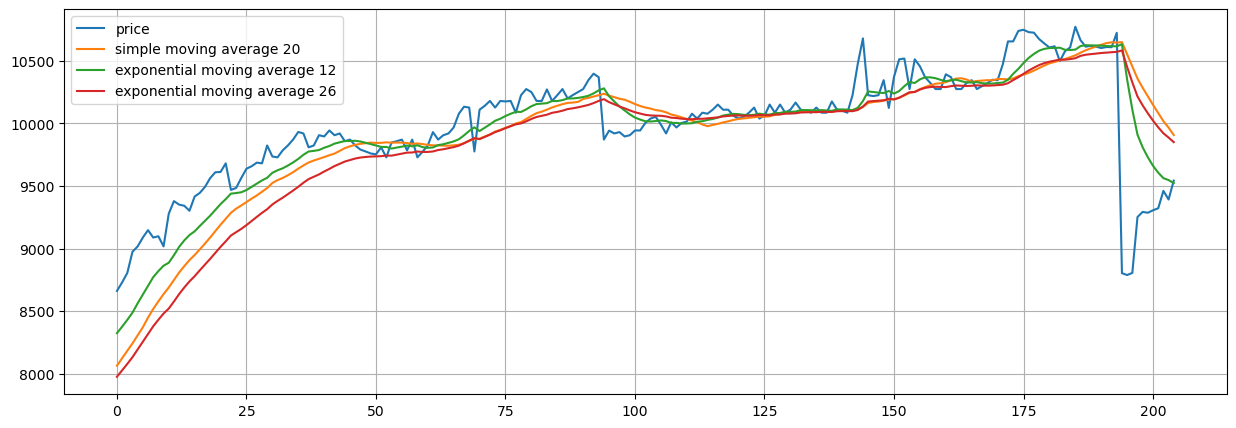

In [78]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['oil_production'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [79]:
scaler = StandardScaler()

In [80]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [81]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [82]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [83]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

[26/Feb/2023 07:37:08] INFO - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [84]:
results = smf.ols('oil_production ~ {}'.format(x_variables), data=train).fit()

In [85]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         oil_production   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           7.16e-81
Time:                        07:37:10   Log-Likelihood:                -1321.1
No. Observations:                 205   AIC:                             2670.
Df Residuals:                     191   BIC:                             2717.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.001e+04    436.610     22.922      0.0

### Drop label col

In [86]:
train.drop(columns=['oil_production'], inplace=True)
val.drop(columns=['oil_production'], inplace=True)

### Logistic Regression Coefficients

In [87]:
y = train['label'].values
X = train.drop(columns=['label'])

In [88]:
X = add_constant(X)

In [89]:
logit = sm.Logit(y, X)

In [91]:
# result = logit.fit()
# print(result.summary())

### Train some basic models

In [92]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

In [93]:
#python program to check if a directory exists
import os
path = run_params["artifact_dir"]
# Check whether the specified path exists or not
isExist = os.path.exists(path)
isExist
# if not isExist:

#    # Create a new directory because it does not exist
#    os.makedirs(path)
#    print("The new directory is created!")

True

In [94]:
experiment_name = run_params['experiment']
artifact_repository = './mlflow'

# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

In [96]:
# X_val

[26/Feb/2023 07:37:37] INFO - AUC: 0.747 | Recall: 0.692 | Precision: 0.900 | F1: 0.783
[26/Feb/2023 07:37:37] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\Logistic_Regression_RU_mertics.yaml
[26/Feb/2023 07:37:38] INFO - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\roc_curve_Logistic_Regression (auc = 0.75).png
[26/Feb/2023 07:37:38] INFO - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/plots/precision_recall_Logistic_Regression prec= 0.90 recall= 0.69.png
[26/Feb/2023 07:37:38] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Logistic_Regression.pickle
C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Logistic_Regression.pickle


Successfully registered model 'RU_Logistic_Regression'.
2023/02/26 07:37:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RU_Logistic_Regression, version 1
Created version '1' of model 'RU_Logistic_Regression'.


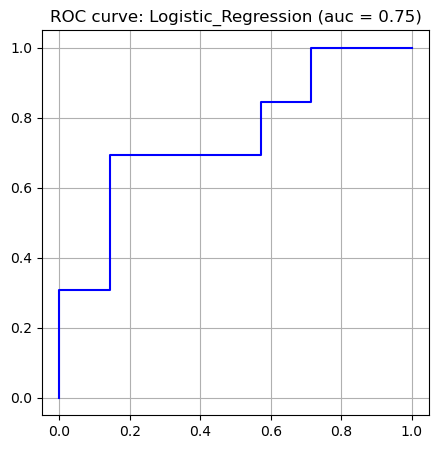

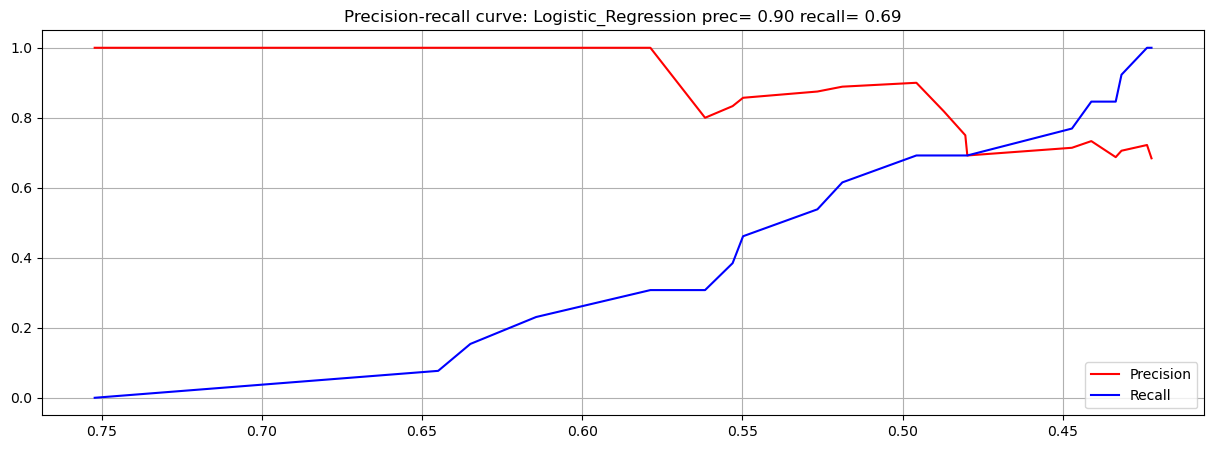

In [97]:
# Logistic regression
model_name = 'Logistic_Regression'
model = LogisticRegression(fit_intercept=FIT_INTERCEPT).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(experiment_id,run_params, model, model_name, y_val, pred)

[26/Feb/2023 07:37:42] INFO - AUC: 0.538 | Recall: 1.000 | Precision: 0.684 | F1: 0.813
[26/Feb/2023 07:37:42] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\Support_Vector_Classifier_RU_mertics.yaml
[26/Feb/2023 07:37:42] INFO - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\roc_curve_Support_Vector_Classifier (auc = 0.54).png
[26/Feb/2023 07:37:42] INFO - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/plots/precision_recall_Support_Vector_Classifier prec= 0.68 recall= 1.00.png
[26/Feb/2023 07:37:42] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Support_Vector_Classifier.pickle
C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Support_Vector_Classifier.pickle


Successfully registered model 'RU_Support_Vector_Classifier'.
2023/02/26 07:37:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RU_Support_Vector_Classifier, version 1
Created version '1' of model 'RU_Support_Vector_Classifier'.


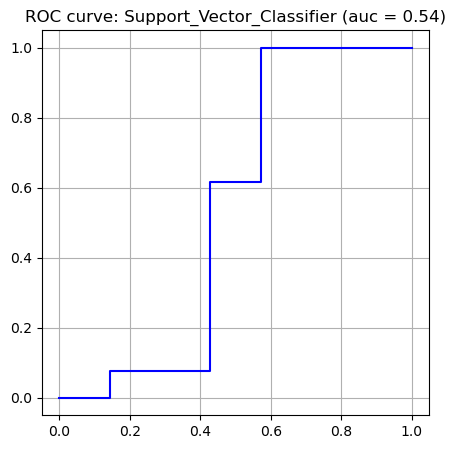

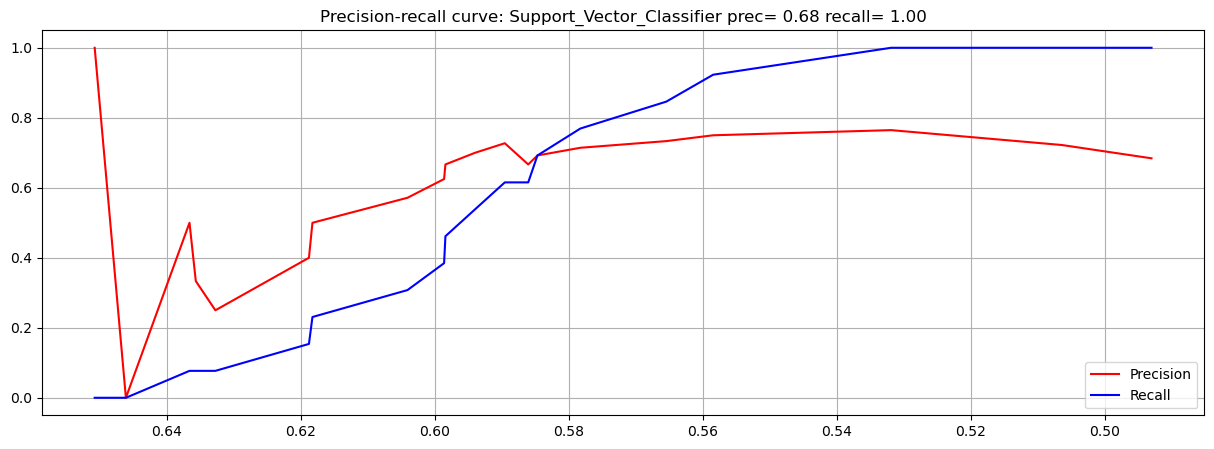

In [98]:
# Support vector classifier
model_name = 'Support_Vector_Classifier'
model = SVC(gamma=GAMMA, C=C_VALUE, probability=PROBABILITY).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(experiment_id,run_params, model, model_name, y_val, pred)



[26/Feb/2023 07:37:46] INFO - AUC: 0.500 | Recall: 0.462 | Precision: 0.600 | F1: 0.522
[26/Feb/2023 07:37:46] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\K_nearest_Neighbours_RU_mertics.yaml
[26/Feb/2023 07:37:46] INFO - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\roc_curve_K_nearest_Neighbours (auc = 0.50).png
[26/Feb/2023 07:37:46] INFO - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/plots/precision_recall_K_nearest_Neighbours prec= 0.60 recall= 0.46.png
[26/Feb/2023 07:37:46] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/K_nearest_Neighbours.pickle
C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/K_nearest_Neighbours.pickle


Successfully registered model 'RU_K_nearest_Neighbours'.
2023/02/26 07:37:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RU_K_nearest_Neighbours, version 1
Created version '1' of model 'RU_K_nearest_Neighbours'.


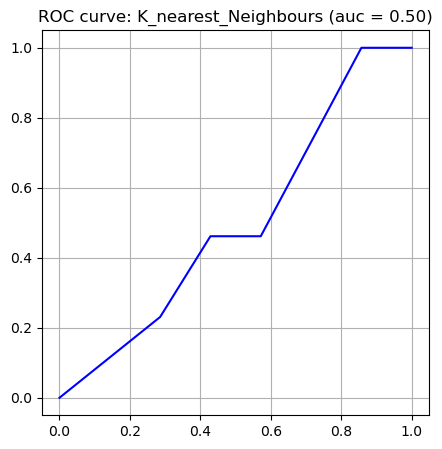

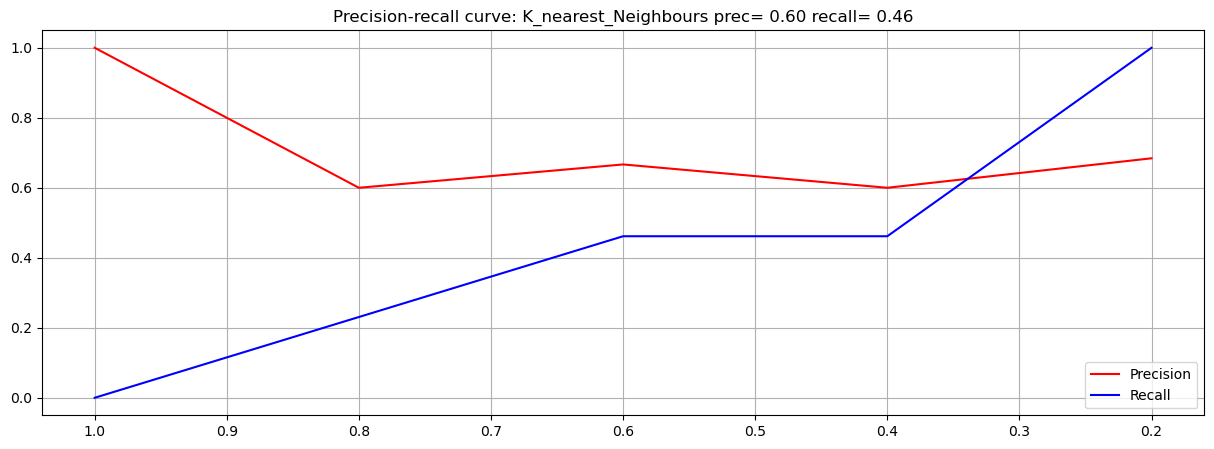

In [99]:
experiment_id,# K-neighbours
model_name = 'K_nearest_Neighbours'
model = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(experiment_id,run_params, model, model_name, y_val, pred)


[26/Feb/2023 07:37:51] INFO - AUC: 0.659 | Recall: 0.692 | Precision: 0.750 | F1: 0.720
[26/Feb/2023 07:37:51] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\Gradient_Boosting_Machine_RU_mertics.yaml
[26/Feb/2023 07:37:51] INFO - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\roc_curve_Gradient_Boosting_Machine (auc = 0.66).png
[26/Feb/2023 07:37:51] INFO - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/plots/precision_recall_Gradient_Boosting_Machine prec= 0.75 recall= 0.69.png
[26/Feb/2023 07:37:51] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Gradient_Boosting_Machine.pickle
C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Gradient_Boosting_Machine.pickle


Successfully registered model 'RU_Gradient_Boosting_Machine'.
2023/02/26 07:37:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RU_Gradient_Boosting_Machine, version 1
Created version '1' of model 'RU_Gradient_Boosting_Machine'.


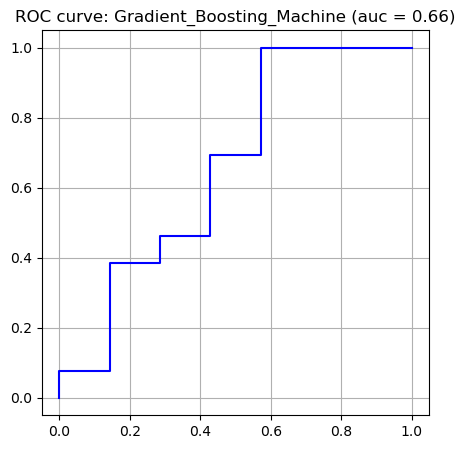

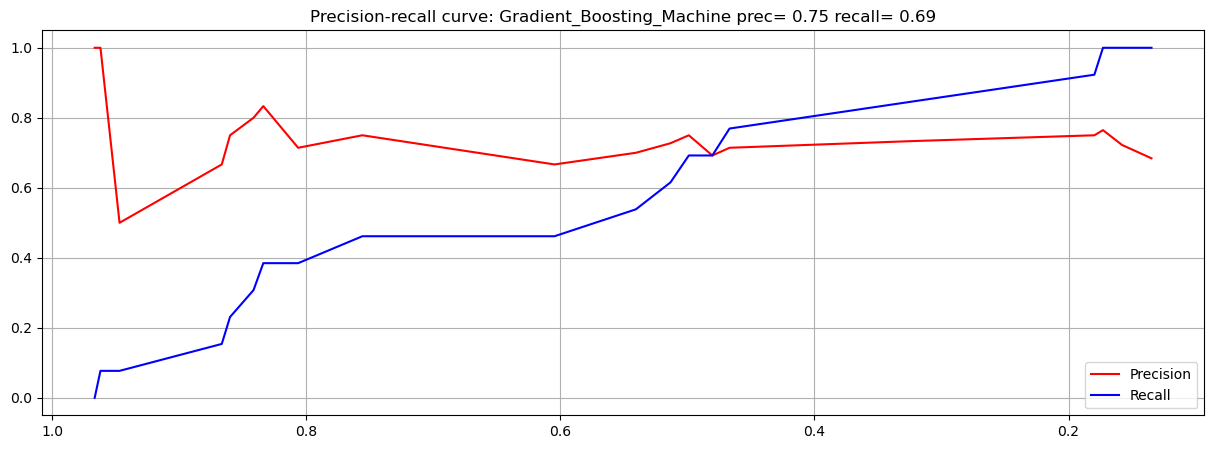

In [100]:
# Gradient Boosting
model_name = 'Gradient_Boosting_Machine'
model = GradientBoostingClassifier(n_estimators=N_ESTIMATORS).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(experiment_id,run_params, model, model_name, y_val, pred)

[26/Feb/2023 07:37:56] INFO - AUC: 0.516 | Recall: 0.308 | Precision: 0.571 | F1: 0.400
[26/Feb/2023 07:37:56] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\Extra_Trees_RU_mertics.yaml
[26/Feb/2023 07:37:56] INFO - ROC curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\roc_curve_Extra_Trees (auc = 0.52).png
[26/Feb/2023 07:37:56] INFO - Precision-recall curve saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/plots/precision_recall_Extra_Trees prec= 0.57 recall= 0.31.png
[26/Feb/2023 07:37:56] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Extra_Trees.pickle
C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/Extra_Trees.pickle


Successfully registered model 'RU_Extra_Trees'.
2023/02/26 07:38:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RU_Extra_Trees, version 1
Created version '1' of model 'RU_Extra_Trees'.


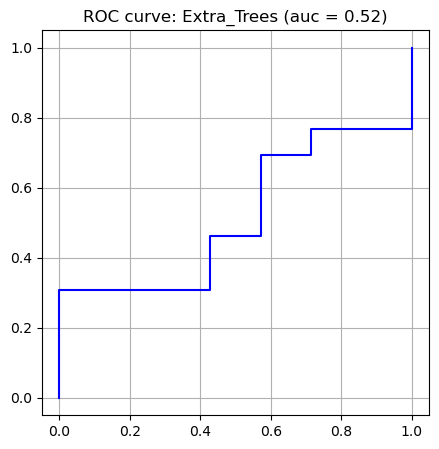

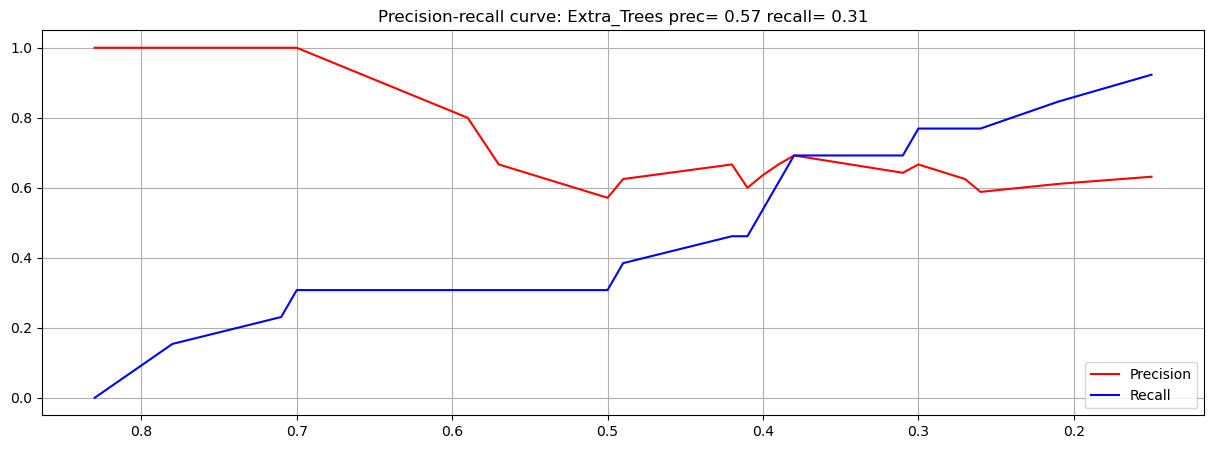

In [101]:
# Bagged trees
model_name = 'Extra_Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(experiment_id,run_params, model, model_name, y_val, pred)

### Test loading model

In [102]:
model_name = 'Support_Vector_Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [103]:
check_model

SVC(C=1, gamma=2, probability=True)

In [104]:
pred = check_model.predict_proba(X_val)[:, 1]

In [105]:
evaluate_binary(y_val, pred)

[26/Feb/2023 07:38:00] INFO - AUC: 0.538 | Recall: 1.000 | Precision: 0.684 | F1: 0.813


(0.5384615384615385, 1.0, 0.6842105263157895, 0.8125000000000001)